In [ ]:
import pandas as pd
import numpy as np

import requests
import re
from bs4 import BeautifulSoup
import difflib
from tqdm import tqdm
import os

Preparation: Get paths to the pdfs

In [6]:
path_constant_part = "C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/Study PDFs/"

pdf_path_dict = {
    1: '33_weisenberger.pdf',
    2: '714_brewster.pdf',
    3: '32_metzger.pdf',
    4: '40_buil.pdf', 
    5: '84_buil.pdf', 
    11: '253_gamper.pdf',
    12: '23_manabe.pdf', 
    13: '85_matsumura.pdf',
    15: '94_tessendorf.pdf',
    18: '1_lissermann.pdf',
    20: '93_sahni.pdf',
    21: '7_bedri.pdf',
    25: '19_weigel.pdf',
    27: '34_laput.pdf',
    30: '17_ando.pdf',
    33: '22_kikuchi.pdf',
    35: '12_matthies.pdf',
    38: '177_carioli.pdf',
    41: '18_lee.pdf',
    42: '610_min.pdf',
    45: '8_amesaka.pdf',
    46: '80_ferlini.pdf',
    47: '77_hoelzemann.pdf',
    51: '78_odoemelem.pdf',
    54: '27_yan.pdf',
    55: '223_cao.pdf',
    61: '26_xu.pdf',
    62: '611_yang.pdf',
    63: '229_fan.pdf',
    65: '258_gashi.pdf',
    66: '217_hashem.pdf',
    67: '622_islam.pdf',
    68: '226_jin.pdf',
    71: '224_laporte.pdf',
    72: '626_ma.pdf',
    75: '227_röddiger.pdf',
    79: '608_alkiek.pdf',
    80: '614_bi.pdf',
    81: '452_bi.pdf',
    88: '309_wang.pdf',
    91: '284_alkiek.pdf',
    94: '376_li.pdf',
    95: '308_panda.pdf',
    99: '619_zhang.pdf',
    102: '516_zhu.pdf',
    104: '498_ge.pdf',
    108: '449_ronco.pdf',
    109: '635_sato.pdf',
    114: '639_suzuki.pdf',
    115: '286_wang.pdf',
    116: '532_wang.pdf',
    117: '676_wang.pdf',
    119: '354_yang.pdf',
}

pdf_path_dict_keys = list(pdf_path_dict.keys())

Extract the Authors from the PDFs and find matching authors

In [ ]:
df_id_authors = pd.DataFrame(columns=['ID', 'Authors'])

for i in tqdm(range(120)): 
    if i in pdf_path_dict_keys:
        
        pdf_path = f'{path_constant_part}{pdf_path_dict[i]}'
        
        # Read the file content within the with block
        with open(pdf_path, "rb") as pdf_file:
            pdf_content = pdf_file.read()
        
        # Use the content in the request
        files = {"input": ("filename.pdf", pdf_content, "application/pdf")}
            
        response_header = requests.post("http://localhost:8070/api/processHeaderDocument", files=files)
        response_string = response_header.text  # TEI XML output
        
        author_extract = re.search(r'author\s*=\s*\{(.*?)\}', response_string)
        if author_extract:
            author_string = author_extract.group(1)
            # Split by 'and' to get individual authors
            authors_raw = [author.strip() for author in author_string.split(' and ')]
            
            # Reverse "Last, First" to "First Last" format
            authors = []
            for author in authors_raw:
                if ',' in author:
                    last_name, first_name = author.split(',', 1)
                    full_name = f"{first_name.strip()} {last_name.strip()}"
                    authors.append(full_name)
                else:
                    # If there's no comma, keep the name as is
                    authors.append(author)
                    
        df_id_authors.loc[len(df_id_authors)] = [i, authors]
            

100%|██████████| 120/120 [01:51<00:00,  1.08it/s]


,ID,Authors
0,1,"[Janet Weisenbercer, Arnold Heidbreder, James Miller]"
1,2,"[Stephen Brewster, Joanna Lumsden, Marek Bell, Malcolm Hall, Stuart Tasker]"
2,3,"[Christian Metzger, Matt Anderson, Thad Starner]"
3,4,"[Vincent Buil, Gerard Hollemans]"
4,5,"[Vincent Buil, Gerard Hollemans, Sander Van De Wijdeven]"
5,11,"[Hannes Gamper, Sakari Tervo, Tapio Lokki]"
6,12,"[Hiroyuki Manabe, Masaaki Fukumoto]"
7,13,"[Kohei Matsumura, Daisuke Sakamoto, Takeo Igarashi]"
8,15,"[Bernd Tessendorf, Peter Derleth, Manuela Feilner, Franz Gravenhorst, Andreas Kettner, Daniel Roggen, Thomas Stiefmeier, Gerhard Tröster]"
9,18,"[Roman Lissermann, Jochen Huber, Aristotelis Hadjakos, Suranga Nanayakkara, Max Ühlhäuser]"


In [23]:
# Set display options to show all content
pd.set_option('display.max_colwidth', None)  # Show full column content
pd.set_option('display.width', 1000)  # Wide display

df_id_authors.head(60)

,ID,Authors
0,1,"[Janet Weisenbercer, Arnold Heidbreder, James Miller]"
1,2,"[Stephen Brewster, Joanna Lumsden, Marek Bell, Malcolm Hall, Stuart Tasker]"
2,3,"[Christian Metzger, Matt Anderson, Thad Starner]"
3,4,"[Vincent Buil, Gerard Hollemans]"
4,5,"[Vincent Buil, Gerard Hollemans, Sander Van De Wijdeven]"
5,11,"[Hannes Gamper, Sakari Tervo, Tapio Lokki]"
6,12,"[Hiroyuki Manabe, Masaaki Fukumoto]"
7,13,"[Kohei Matsumura, Daisuke Sakamoto, Takeo Igarashi]"
8,15,"[Bernd Tessendorf, Peter Derleth, Manuela Feilner, Franz Gravenhorst, Andreas Kettner, Daniel Roggen, Thomas Stiefmeier, Gerhard Tröster]"
9,18,"[Roman Lissermann, Jochen Huber, Aristotelis Hadjakos, Suranga Nanayakkara, Max Ühlhäuser]"


In [35]:
# Manual replacements
df_id_authors.at[df_id_authors[df_id_authors['ID'] == 25].index[0], 'Authors'] = ["Martin Weigel", "Tong Lu", "Gilles Bailly", "Antti Oulasvirta", "Carmel Majidi", "Jürgen Steimle"]
df_id_authors.at[df_id_authors[df_id_authors['ID'] == 27].index[0], 'Authors'] = ['Gierad Xiang', 'Anthony Chen', 'Chris Harrison']
df_id_authors.at[df_id_authors[df_id_authors['ID'] == 81].index[0], 'Authors'] = ['Hongliang Bi', 'Yuanyuan Sun', 'Jiajia Liu', 'Lihao Coa']
df_id_authors.at[df_id_authors[df_id_authors['ID'] == 99].index[0], 'Authors'] = ['Yuke Zhang', 'Ken Takaki', 'Hiroaki Murakami', 'Takuya Sasatani', 'Yoshihiro Kawahara']
df_id_authors.at[df_id_authors[df_id_authors['ID'] == 115].index[0], 'Authors'] = ['Zi Wang', 'Yilin Wang', 'Jie Yang']


In [36]:
# Extract all authors into a flat list
all_authors = []
for authors_list in df_id_authors['Authors']:
    all_authors.extend(authors_list)

# Count occurrences of each author
author_counts = pd.Series(all_authors).value_counts().reset_index()
author_counts.columns = ['Author', 'Count']

# Sort first by count (descending) and then by author name (ascending)
author_counts = author_counts.sort_values(['Count', 'Author'], ascending=[False, True])

# Display the results
author_counts

,Author,Count
3,Hiroki Watanabe,3
0,Khaled Alkiek,3
4,Khaled Harras,3
1,Moustafa Youssef,3
2,Takashi Amesaka,3
...,...,...
119,Zehua Gue,1
114,Zehua Guo,1
41,Zhijian Yang,1
87,Zisu Li,1


In [37]:
# Get list of unique paper IDs
unique_ids = df_id_authors['ID'].unique()

# Create an empty DataFrame with paper IDs as row and column indices
coauthor_matrix = pd.DataFrame(0, index=unique_ids, columns=unique_ids)

# Create a dictionary mapping paper IDs to their authors for faster lookup
id_to_authors = {row['ID']: set(row['Authors']) for _, row in df_id_authors.iterrows()}

# Iterate through each pair of papers (only checking each pair once)
for i, id_i in enumerate(unique_ids):
    authors_i = id_to_authors[id_i]
    
    for id_j in unique_ids[i+1:]:  # Start from i+1 to avoid duplicate checks
        authors_j = id_to_authors[id_j]
        
        # Check if papers share any authors
        if len(authors_i.intersection(authors_j)) > 0:
            coauthor_matrix.loc[id_i, id_j] = 1
            coauthor_matrix.loc[id_j, id_i] = 1  # Matrix is symmetric

coauthor_matrix.to_csv('interconnections_datasets/coauthor_matrix.csv')

# Display first few rows and columns
coauthor_matrix.head()

,1,2,3,4,5,11,12,13,15,18,...,99,102,104,108,109,114,115,116,117,119
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Get the Citation Matrix of out of the PDFs

In [ ]:
# DF with ID and bibtex
df_id_bibtex = pd.read_excel('interconnections_datasets/bibtex_mapping_of_ids.xlsx')

In [ ]:
# Function to extract references from a paper using GROBID and convert to BibTeX
def extract_references_to_bibtex(pdf_path):
    """Extract references from PDF using GROBID and convert to BibTeX format"""
    references = []
    
    try:
        # Read PDF content
        with open(pdf_path, "rb") as pdf_file:
            pdf_content = pdf_file.read()
        
        # Request GROBID to process references
        files = {"input": ("document.pdf", pdf_content, "application/pdf")}
        response = requests.post(
            "http://localhost:8070/api/processReferences", 
            files=files, 
            timeout=300
        )
        
        if response.status_code != 200:
            print(f"Error from GROBID API: {response.status_code}")
            return []
            
        # Parse XML response
        soup = BeautifulSoup(response.text, 'xml')
        
        for i, bibl in enumerate(soup.find_all('biblStruct')):
            # Extract key citation components
            ref_id = bibl.get('xml:id', f'ref_{i}')
            
            # Authors
            authors = []
            for author_tag in bibl.find_all('author'):
                person = author_tag.find('persName')
                if person:
                    surname = person.find('surname')
                    forename = person.find('forename')
                    
                    if surname:
                        author_name = surname.text
                        if forename:
                            author_name = f"{author_name}, {forename.text}"
                        authors.append(author_name)
            
            # Title
            title = ""
            title_tag = bibl.find('title', {'level': 'a'})
            if title_tag:
                title = title_tag.text.strip()
            
            # Year
            year = ""
            date_tag = bibl.find('date', {'type': 'published'})
            if date_tag and date_tag.get('when'):
                year = date_tag.get('when').split('-')[0]  # Extract year from date
            
            # Journal/Conference
            journal = ""
            journal_tag = bibl.find('title', {'level': 'j'})
            if journal_tag:
                journal = journal_tag.text.strip()
            else:
                book_tag = bibl.find('title', {'level': 'm'})
                if book_tag:
                    journal = book_tag.text.strip()
            
            # Volume, Issue, Pages
            volume = ""
            vol_tag = bibl.find('biblScope', {'unit': 'volume'})
            if vol_tag:
                volume = vol_tag.text.strip()
            
            issue = ""
            issue_tag = bibl.find('biblScope', {'unit': 'issue'})
            if issue_tag:
                issue = issue_tag.text.strip()
            
            pages = ""
            pages_from_tag = bibl.find('biblScope', {'unit': 'page', 'from': True})
            pages_to_tag = bibl.find('biblScope', {'unit': 'page', 'to': True})
            if pages_from_tag and pages_to_tag:
                pages = f"{pages_from_tag.get('from')}--{pages_to_tag.get('to')}"
            elif pages_from_tag:
                pages = pages_from_tag.get('from')
            
            # DOI
            doi = ""
            doi_tag = bibl.find('idno', {'type': 'DOI'})
            if doi_tag:
                doi = doi_tag.text.strip()
            
            # Create BibTeX entry
            bibtex_id = f"grobid_{ref_id.replace('b', '')}"
            bibtex_str = f"@article{{{bibtex_id},\n"
            
            if authors:
                bibtex_str += f"  author = {{{' and '.join(authors)}}},\n"
            if title:
                bibtex_str += f"  title = {{{title}}},\n"
            if journal:
                bibtex_str += f"  journal = {{{journal}}},\n"
            if year:
                bibtex_str += f"  year = {{{year}}},\n"
            if volume:
                bibtex_str += f"  volume = {{{volume}}},\n"
            if issue:
                bibtex_str += f"  number = {{{issue}}},\n"
            if pages:
                bibtex_str += f"  pages = {{{pages}}},\n"
            if doi:
                bibtex_str += f"  doi = {{{doi}}},\n"
                
            bibtex_str += "}"
            
            # Create structured citation data
            citation = {
                'bibtex': bibtex_str,
                'authors': authors,
                'title': title,
                'year': year,
                'journal': journal,
                'doi': doi,
                'raw_xml': str(bibl),
                'author_last_names': [a.split(',')[0].lower().strip() if ',' in a else a.split()[-1].lower().strip() 
                                      for a in authors]
            }
            
            references.append(citation)
            
    except Exception as e:
        print(f"Error extracting references: {str(e)}")
    
    return references

In [ ]:
# Function to normalize BibTeX entries for comparison
def normalize_bibtex_for_comparison(bibtex_str):
    """Extract key information from BibTeX for comparison"""
    result = {
        'authors': [],
        'title': '',
        'year': '',
        'journal': '',
        'doi': '',
        'author_last_names': []
    }
    
    # Extract authors
    author_match = re.search(r'author\s*=\s*\{(.*?)\}', bibtex_str, re.DOTALL)
    if author_match:
        authors_str = author_match.group(1)
        authors = [a.strip() for a in authors_str.split(' and ')]
        result['authors'] = authors
        # Extract last names
        result['author_last_names'] = [a.split(',')[0].lower().strip() if ',' in a 
                                      else a.split()[-1].lower().strip() 
                                      for a in authors]
    
    # Extract title
    title_match = re.search(r'title\s*=\s*\{(.*?)\}', bibtex_str, re.DOTALL)
    if title_match:
        result['title'] = re.sub(r'[\{\}]', '', title_match.group(1).lower())
    
    # Extract year
    year_match = re.search(r'year\s*=\s*\{?(\d{4})\}?', bibtex_str)
    if year_match:
        result['year'] = year_match.group(1)
    
    # Extract journal or booktitle
    journal_match = re.search(r'journal\s*=\s*\{(.*?)\}', bibtex_str, re.DOTALL)
    if not journal_match:
        journal_match = re.search(r'booktitle\s*=\s*\{(.*?)\}', bibtex_str, re.DOTALL)
    if journal_match:
        result['journal'] = journal_match.group(1).lower()
    
    # Extract DOI
    doi_match = re.search(r'doi\s*=\s*\{(.*?)\}', bibtex_str, re.DOTALL)
    if doi_match:
        result['doi'] = doi_match.group(1).lower()
    
    return result

In [ ]:
# Function to match citation with corpus papers
def match_citation_to_corpus(citation_data, corpus_entries, citing_paper_id, threshold=0.5):
    """Match a citation to papers in the corpus"""
    matches = []
    
    # Extract normalized data from citation
    citation_title = citation_data.get('title', '').lower()
    citation_title = re.sub(r'[^\w\s]', '', citation_title)
    citation_year = citation_data.get('year', '')
    citation_authors = citation_data.get('author_last_names', [])
    citation_doi = citation_data.get('doi', '').lower()
    
    for paper_id, paper_data in corpus_entries.items():
        # Skip self-citations (ADDED)
        if paper_id == citing_paper_id:
            continue
            
        score = 0
        max_score = 0
        match_details = {}
        
        # Extract normalized data from corpus entry
        paper_title = paper_data.get('title', '').lower()
        paper_title = re.sub(r'[^\w\s]', '', paper_title)
        paper_year = paper_data.get('year', '')
        paper_authors = paper_data.get('author_last_names', [])
        paper_doi = paper_data.get('doi', '').lower()
        
        # Match by DOI (highest confidence)
        if citation_doi and paper_doi and citation_doi == paper_doi:
            return [{'paper_id': paper_id, 'score': 1.0, 'match_type': 'doi'}]
        
        # Match by authors (up to 2 points)
        if citation_authors and paper_authors:
            max_score += 2
            matching_authors = set(citation_authors) & set(paper_authors)
            if matching_authors:
                author_score = min(2, len(matching_authors))
                score += author_score
                match_details['matching_authors'] = list(matching_authors)
        
        # Match by year (1 point)
        if citation_year and paper_year:
            max_score += 1
            if citation_year == paper_year:
                score += 1
                match_details['year_match'] = True
        
        # Match by title (5 points max)
        if citation_title and paper_title:
            max_score += 5
            
            # Calculate title similarity
            title_similarity = difflib.SequenceMatcher(None, citation_title, paper_title).ratio()
            
            # Check for title containment (special case)
            if (len(citation_title) > 10 and len(paper_title) > 10):
                if citation_title in paper_title or paper_title in citation_title:
                    title_similarity = max(title_similarity, 0.8)
            
            title_score = title_similarity * 5
            score += title_score
            match_details['title_similarity'] = title_similarity
        
        # Calculate final score
        if max_score > 0:
            final_score = score / max_score
            if final_score >= threshold:
                matches.append({
                    'paper_id': paper_id,
                    'score': final_score,
                    'details': match_details
                })
    
    # Sort matches by score
    matches.sort(key=lambda x: x['score'], reverse=True)
    return matches

In [ ]:
# Function to build citation network with user confirmation for uncertain matches
def build_citation_network(df_id_bibtex, pdf_path_dict, path_constant_part):
    """Build a citation network from papers and their references"""
    print("Preparing citation network analysis...")
    
    # Step 1: Create normalized corpus entries from BibTeX data
    print("Normalizing corpus BibTeX entries...")
    corpus_entries = {}
    
    for _, row in df_id_bibtex.iterrows():
        paper_id = row['ID']
        bibtex_str = row['Bibtex'] if isinstance(row['Bibtex'], str) else ""
        
        if bibtex_str:
            normalized_data = normalize_bibtex_for_comparison(bibtex_str)
            corpus_entries[paper_id] = normalized_data
    
    print(f"Normalized {len(corpus_entries)} papers in corpus")
    
    # Step 2: Initialize citation matrix
    paper_ids = list(corpus_entries.keys())
    citation_matrix = pd.DataFrame(0, index=paper_ids, columns=paper_ids)
    
    # Step 3: Extract all references first (MODIFIED APPROACH)
    print("First extracting all references from papers...")
    all_paper_references = {}
    
    # Create output directory for citations
    os.makedirs("extracted_citations", exist_ok=True)
    
    for paper_id in tqdm(corpus_entries.keys()):
        if paper_id in pdf_path_dict:
            pdf_path = f"{path_constant_part}{pdf_path_dict[paper_id]}"
            
            # Extract references
            print(f"\nExtracting references from paper {paper_id}...")
            references = extract_references_to_bibtex(pdf_path)
            print(f"Found {len(references)} references in paper {paper_id}")
            
            # Save references to file
            with open(f"extracted_citations/paper_{paper_id}_citations.bib", "w", encoding="utf-8") as f:
                for ref in references:
                    f.write(ref['bibtex'] + "\n\n")
            
            all_paper_references[paper_id] = references
    
    # Step 4: Match references to corpus and collect uncertain matches
    print("\nMatching references to corpus papers...")
    citation_details = {}
    uncertain_matches = []  # Store uncertain matches for later confirmation
    
    for citing_id, references in all_paper_references.items():
        citation_details[citing_id] = []
        
        for ref in references:
            matches = match_citation_to_corpus(ref, corpus_entries, citing_id)  # Pass citing_id to prevent self-citations
            
            if matches:
                best_match = matches[0]
                cited_id = best_match['paper_id']
                match_score = best_match['score']
                
                # High-confidence match (add directly)
                if match_score >= 0.7:
                    citation_matrix.loc[citing_id, cited_id] = 1
                    citation_details[citing_id].append({
                        'cited_id': cited_id,
                        'score': match_score,
                        'details': best_match.get('details', {}),
                        'citation_text': ref.get('title', '')
                    })
                    print(f"✓ Paper {citing_id} cites paper {cited_id} (score: {match_score:.2f})")
                
                # Uncertain match (store for confirmation)
                elif match_score >= 0.5:
                    uncertain_matches.append({
                        'citing_id': citing_id,
                        'cited_id': cited_id,
                        'score': match_score,
                        'ref': ref,
                        'details': best_match.get('details', {})
                    })
                    print(f"? Uncertain match: Paper {citing_id} possibly cites paper {cited_id} (score: {match_score:.2f})")
    
    # Step 5: Ask for confirmation of uncertain matches
    if uncertain_matches:
        print("\n\n=== UNCERTAIN MATCHES REQUIRING CONFIRMATION ===")
        for i, match in enumerate(uncertain_matches):
            citing_id = match['citing_id']
            cited_id = match['cited_id']
            score = match['score']
            ref = match['ref']
            
            print(f"\nMatch {i+1}/{len(uncertain_matches)}")
            print(f"Paper {citing_id} possibly cites Paper {cited_id} (score: {score:.2f})")
            print(f"Citation title: {ref.get('title', 'No title')}")
            print(f"Citation authors: {', '.join(ref.get('authors', ['No authors']))}")
            print(f"Citation year: {ref.get('year', 'No year')}")
            
            # Print matching details
            if 'details' in match:
                if 'matching_authors' in match['details']:
                    print(f"Matching authors: {', '.join(match['details']['matching_authors'])}")
                if 'title_similarity' in match['details']:
                    print(f"Title similarity: {match['details']['title_similarity']:.2f}")
                if 'year_match' in match['details']:
                    print("Year matches ✓")
            
            # Get user confirmation
            confirmation = input(f"\nConfirm this citation? (y/n): ").strip().lower()
            
            if confirmation == 'y':
                citation_matrix.loc[citing_id, cited_id] = 1
                citation_details[citing_id].append({
                    'cited_id': cited_id,
                    'score': score,
                    'details': match.get('details', {}),
                    'citation_text': ref.get('title', ''),
                    'status': 'confirmed'
                })
                print(f"Added: Paper {citing_id} cites paper {cited_id}")
            else:
                print(f"Skipped: Paper {citing_id} does not cite paper {cited_id}")
    
    return citation_matrix, citation_details

Preparing citation network analysis...
Normalizing corpus BibTeX entries...
Normalized 53 papers in corpus
First extracting all references from papers...


  0%|          | 0/53 [00:00<?, ?it/s]


Extracting references from paper 1...


  2%|▏         | 1/53 [00:04<04:02,  4.66s/it]

Found 11 references in paper 1

Extracting references from paper 2...


  4%|▍         | 2/53 [00:08<03:40,  4.33s/it]

Found 15 references in paper 2

Extracting references from paper 3...


  6%|▌         | 3/53 [00:09<02:25,  2.92s/it]

Found 5 references in paper 3

Extracting references from paper 4...


  8%|▊         | 4/53 [00:11<01:50,  2.25s/it]

Found 8 references in paper 4

Extracting references from paper 5...


  9%|▉         | 5/53 [00:14<02:05,  2.61s/it]

Found 10 references in paper 5

Extracting references from paper 11...


 11%|█▏        | 6/53 [00:15<01:43,  2.20s/it]

Found 10 references in paper 11

Extracting references from paper 12...


 13%|█▎        | 7/53 [00:25<03:29,  4.55s/it]

Found 12 references in paper 12

Extracting references from paper 13...


 15%|█▌        | 8/53 [00:26<02:35,  3.46s/it]

Found 4 references in paper 13

Extracting references from paper 15...


 17%|█▋        | 9/53 [00:27<02:04,  2.84s/it]

Found 12 references in paper 15

Extracting references from paper 18...


 19%|█▉        | 10/53 [00:30<01:58,  2.77s/it]

Found 34 references in paper 18

Extracting references from paper 20...


 21%|██        | 11/53 [00:33<02:01,  2.89s/it]

Found 39 references in paper 20

Extracting references from paper 21...


 23%|██▎       | 12/53 [00:34<01:38,  2.40s/it]

Found 9 references in paper 21

Extracting references from paper 25...


 25%|██▍       | 13/53 [00:36<01:31,  2.29s/it]

Found 42 references in paper 25

Extracting references from paper 27...


 26%|██▋       | 14/53 [00:38<01:23,  2.15s/it]

Found 24 references in paper 27

Extracting references from paper 30...


 28%|██▊       | 15/53 [00:40<01:21,  2.16s/it]

Found 37 references in paper 30

Extracting references from paper 33...


 30%|███       | 16/53 [00:42<01:13,  1.99s/it]

Found 24 references in paper 33

Extracting references from paper 35...


 32%|███▏      | 17/53 [00:44<01:13,  2.04s/it]

Found 46 references in paper 35

Extracting references from paper 38...


 34%|███▍      | 18/53 [00:46<01:12,  2.06s/it]

Found 37 references in paper 38

Extracting references from paper 41...


 36%|███▌      | 19/53 [00:49<01:18,  2.29s/it]

Found 45 references in paper 41

Extracting references from paper 42...


 38%|███▊      | 20/53 [00:51<01:10,  2.13s/it]

Found 17 references in paper 42

Extracting references from paper 45...


 40%|███▉      | 21/53 [00:54<01:20,  2.51s/it]

Found 17 references in paper 45

Extracting references from paper 46...


 42%|████▏     | 22/53 [00:56<01:08,  2.20s/it]

Found 15 references in paper 46

Extracting references from paper 47...


 43%|████▎     | 23/53 [00:58<01:01,  2.06s/it]

Found 20 references in paper 47

Extracting references from paper 51...


 45%|████▌     | 24/53 [00:59<00:52,  1.82s/it]

Found 4 references in paper 51

Extracting references from paper 54...


 47%|████▋     | 25/53 [01:01<00:51,  1.84s/it]

Found 37 references in paper 54

Extracting references from paper 55...


 49%|████▉     | 26/53 [01:08<01:31,  3.39s/it]

Found 61 references in paper 55

Extracting references from paper 61...


 51%|█████     | 27/53 [01:13<01:45,  4.08s/it]

Found 74 references in paper 61

Extracting references from paper 62...


 53%|█████▎    | 28/53 [01:21<02:09,  5.18s/it]

Found 80 references in paper 62

Extracting references from paper 63...


 55%|█████▍    | 29/53 [01:30<02:28,  6.18s/it]

Found 60 references in paper 63

Extracting references from paper 65...


 57%|█████▋    | 30/53 [01:43<03:12,  8.36s/it]

Found 58 references in paper 65

Extracting references from paper 66...


 58%|█████▊    | 31/53 [01:45<02:19,  6.32s/it]

Found 30 references in paper 66

Extracting references from paper 67...


 60%|██████    | 32/53 [01:47<01:44,  5.00s/it]

Found 42 references in paper 67

Extracting references from paper 68...


 62%|██████▏   | 33/53 [01:53<01:46,  5.31s/it]

Found 77 references in paper 68

Extracting references from paper 71...


 64%|██████▍   | 34/53 [01:55<01:26,  4.53s/it]

Found 34 references in paper 71

Extracting references from paper 72...


 66%|██████▌   | 35/53 [02:02<01:35,  5.32s/it]

Found 46 references in paper 72

Extracting references from paper 75...


 68%|██████▊   | 36/53 [02:07<01:27,  5.13s/it]

Found 58 references in paper 75

Extracting references from paper 79...


 70%|██████▉   | 37/53 [02:10<01:12,  4.51s/it]

Found 46 references in paper 79

Extracting references from paper 80...


 72%|███████▏  | 38/53 [02:12<00:55,  3.72s/it]

Found 35 references in paper 80

Extracting references from paper 81...


 74%|███████▎  | 39/53 [02:16<00:53,  3.81s/it]

Found 38 references in paper 81

Extracting references from paper 88...


 75%|███████▌  | 40/53 [02:20<00:50,  3.86s/it]

Found 69 references in paper 88

Extracting references from paper 91...


 77%|███████▋  | 41/53 [02:22<00:38,  3.21s/it]

Found 16 references in paper 91

Extracting references from paper 94...


 79%|███████▉  | 42/53 [02:30<00:50,  4.60s/it]

Found 84 references in paper 94

Extracting references from paper 95...


 81%|████████  | 43/53 [02:34<00:45,  4.55s/it]

Found 87 references in paper 95

Extracting references from paper 99...


 83%|████████▎ | 44/53 [02:35<00:31,  3.54s/it]

Found 3 references in paper 99

Extracting references from paper 102...


 85%|████████▍ | 45/53 [02:39<00:27,  3.48s/it]

Found 37 references in paper 102

Extracting references from paper 104...


 87%|████████▋ | 46/53 [02:42<00:24,  3.44s/it]

Found 29 references in paper 104

Extracting references from paper 108...


 89%|████████▊ | 47/53 [02:49<00:27,  4.51s/it]

Found 46 references in paper 108

Extracting references from paper 109...


 91%|█████████ | 48/53 [02:53<00:21,  4.34s/it]

Found 49 references in paper 109

Extracting references from paper 114...


 92%|█████████▏| 49/53 [02:59<00:19,  4.76s/it]

Found 58 references in paper 114

Extracting references from paper 115...


 94%|█████████▍| 50/53 [03:03<00:14,  4.79s/it]

Found 60 references in paper 115

Extracting references from paper 116...


 96%|█████████▌| 51/53 [03:07<00:08,  4.46s/it]

Found 70 references in paper 116

Extracting references from paper 117...


 98%|█████████▊| 52/53 [03:09<00:03,  3.74s/it]

Found 30 references in paper 117

Extracting references from paper 119...


100%|██████████| 53/53 [03:14<00:00,  3.67s/it]

Found 95 references in paper 119

Matching references to corpus papers...


✓ Paper 4 cites paper 5 (score: 1.00)
✓ Paper 5 cites paper 3 (score: 0.88)
✓ Paper 5 cites paper 2 (score: 0.94)
✓ Paper 5 cites paper 4 (score: 1.00)
✓ Paper 12 cites paper 5 (score: 1.00)
✓ Paper 12 cites paper 2 (score: 1.00)
✓ Paper 12 cites paper 4 (score: 1.00)
✓ Paper 12 cites paper 11 (score: 1.00)
✓ Paper 18 cites paper 5 (score: 1.00)
✓ Paper 18 cites paper 3 (score: 0.86)
? Uncertain match: Paper 18 possibly cites paper 109 (score: 0.57)
? Uncertain match: Paper 20 possibly cites paper 38 (score: 0.52)
? Uncertain match: Paper 20 possibly cites paper 12 (score: 0.53)
? Uncertain match: Paper 21 possibly cites paper 20 (score: 0.67)
✓ Paper 21 cites paper 20 (score: 1.00)
✓ Paper 25 cites paper 18 (score: 1.00)
? Uncertain match: Paper 25 possibly cites paper 13 (score: 0.53)
✓ Paper 27 cites paper 5 (score: 1.00)
✓ Paper 27 cites paper 18 (score: 1.00)
? Uncertain match: Paper 27 possibly cites paper 12 (score: 0.53)
✓ Paper 27 cites paper 3 (score: 0.86)
✓ Paper 30 cites p

C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_12152\2162846820.py:381: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


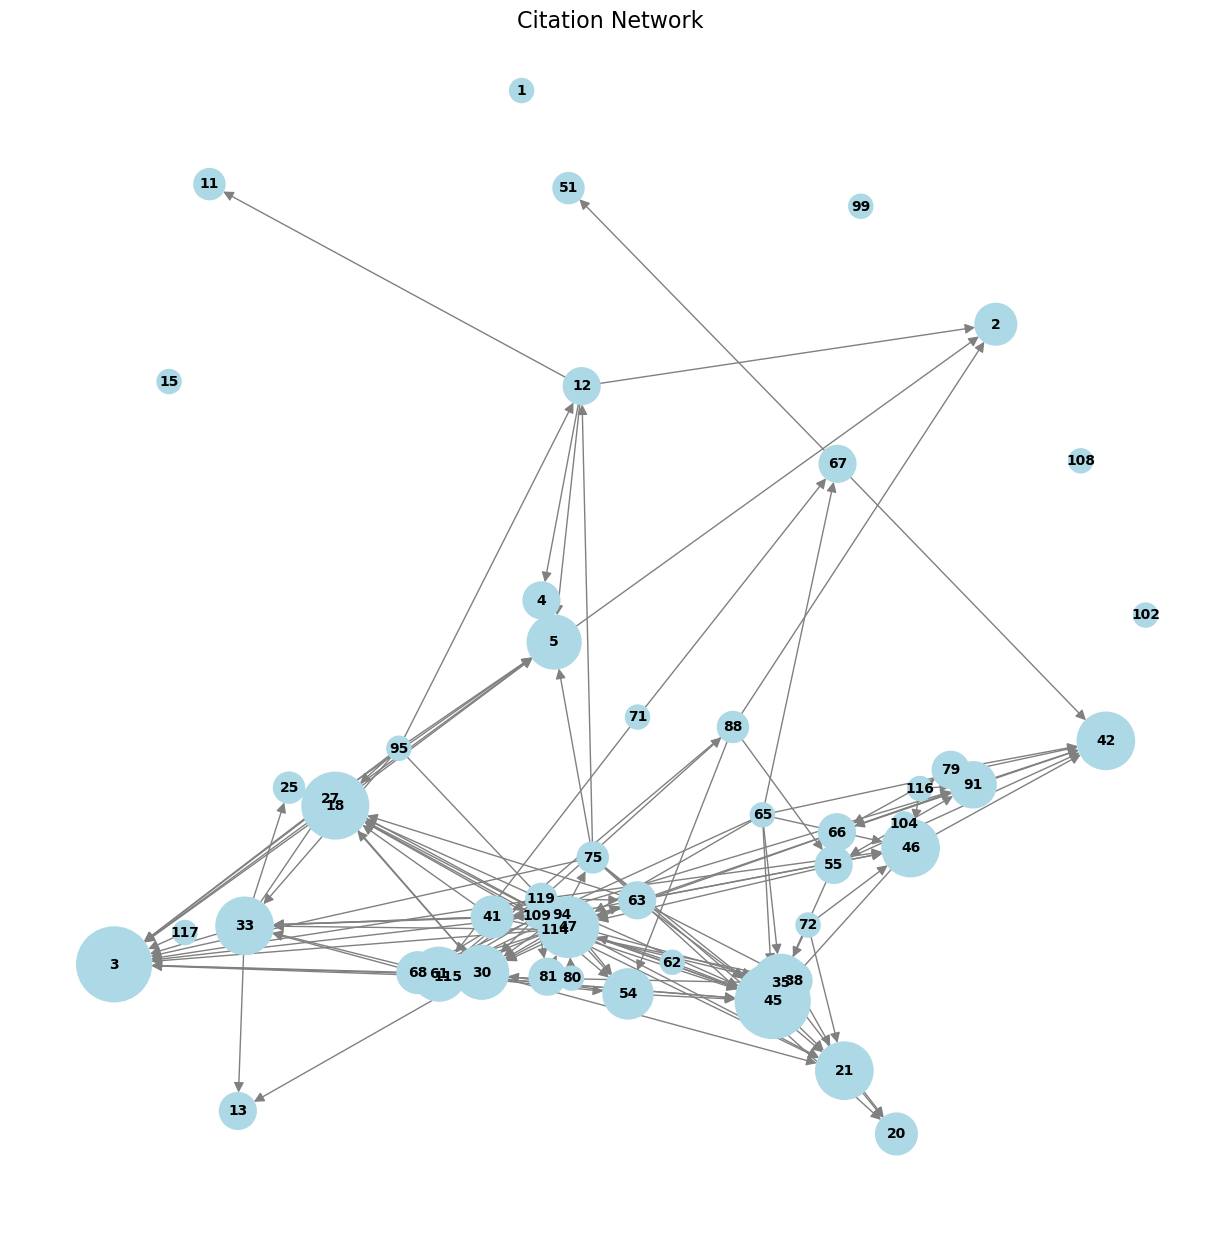


Citation Network Summary:
Total citations between corpus papers: 148
Papers that cite others in the corpus: 41
Papers that are cited by others: 36

Most cited papers:
Paper ID 3: cited 13 times
Paper ID 45: cited 13 times
Paper ID 18: cited 10 times
Paper ID 47: cited 8 times
Paper ID 35: cited 7 times
Paper ID 21: cited 7 times
Paper ID 46: cited 7 times
Paper ID 42: cited 7 times
Paper ID 33: cited 7 times
Paper ID 30: cited 6 times
Paper ID 61: cited 6 times
Paper ID 5: cited 6 times
Paper ID 54: cited 5 times
Paper ID 91: cited 4 times
Paper ID 41: cited 3 times
Paper ID 2: cited 3 times
Paper ID 20: cited 3 times
Paper ID 68: cited 3 times
Paper ID 27: cited 3 times
Paper ID 38: cited 2 times
Paper ID 12: cited 2 times
Paper ID 4: cited 2 times
Paper ID 81: cited 2 times
Paper ID 13: cited 2 times
Paper ID 55: cited 2 times
Paper ID 79: cited 2 times
Paper ID 63: cited 2 times
Paper ID 66: cited 2 times
Paper ID 67: cited 2 times
Paper ID 94: cited 1 times
Paper ID 88: cited 1 ti

In [ ]:
# Execute the full pipeline
citation_matrix, citation_details = build_citation_network(df_id_bibtex, pdf_path_dict, path_constant_part)

# Save citation matrix
citation_matrix.to_csv('interconnections_datasets/citation_matrix.csv')

# Print summary statistics
num_citations = citation_matrix.sum().sum()
num_papers_with_citations = (citation_matrix.sum(axis=1) > 0).sum()
num_papers_cited = (citation_matrix.sum(axis=0) > 0).sum()

print(f"\nCitation Network Summary:")
print(f"Total citations between corpus papers: {num_citations}")
print(f"Papers that cite others in the corpus: {num_papers_with_citations}")
print(f"Papers that are cited by others: {num_papers_cited}")

# Most cited papers
most_cited = citation_matrix.sum(axis=0).sort_values(ascending=False)
print("\nMost cited papers:")
for paper_id, count in most_cited[most_cited > 0].items():
    print(f"Paper ID {paper_id}: cited {count} times")

# Papers with most citations to others
most_citations = citation_matrix.sum(axis=1).sort_values(ascending=False)
print("\nPapers citing most others:")
for paper_id, count in most_citations[most_citations > 0].items():
    print(f"Paper ID {paper_id}: cites {count} other papers")
